# **Лабораторная работа 1**
# Фильтр Байеса

Выполнил: Топольницкий А.А.\
Проверил: Маргун А.А.

### **Формулировка ситуации**
В начале помещения находится мобильный робот с координатой 0 в помещении длиной SIZE.  Робот перемещается вдоль одного направления по ячейкам шириной 1 метр. Исполнительные механизмы робота неидеальны, а также присутствует проскальзывание. Вследствие этого, робот перемещеается в заданную ячейку с вероятностью 40%, в соседнюю с ней - с вероятностью 20%, через одну от нее - 10%. Гистограмма погрешности приведена ниже.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm



<BarContainer object of 5 artists>

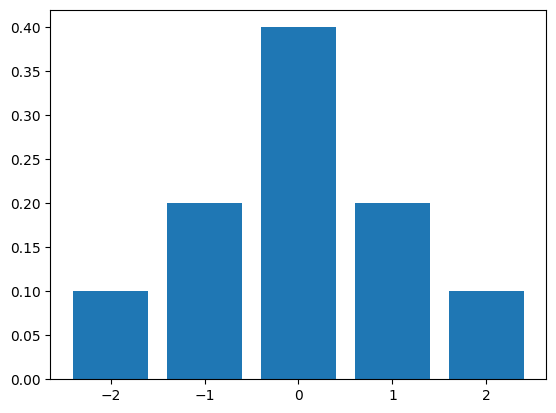

In [ ]:
robot_errors = [-2, -1, 0, 1, 2]
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(robot_errors, robot_prob)

Положение робота измеряется датчиком с нормальным распределением погрешности, математическое ожидание которой соотвествует положению робота. Рапределение погрешности датчика приведено ниже.

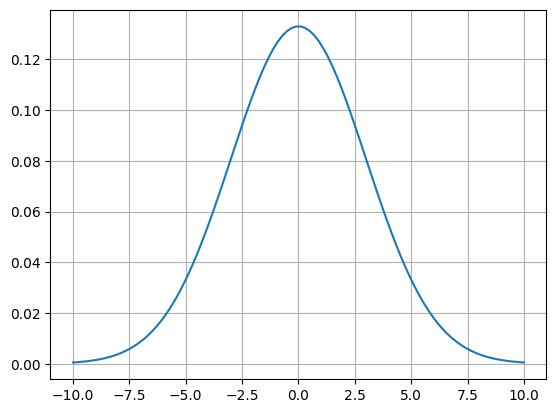

In [ ]:
N = 100
sigma = 3
mu = 0
x = np.linspace(-10, +10, N)
p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
plt.plot(x, p)
plt.grid(True)

Робот выполняет перемещение в произвольно заданную ячейку $N$. После чего измеряет положение датчиком и применяет фильтр Байеса для уточнения своего положения (данные положения робот может запрашивать сколько потребуется раз).

### **Задание**
Требуется:

- Написать программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении (допускается, что робот перемещается в центр ячейки).
- Реализовать функцию, иммитируюущую измерение положения робота датчиком.
- Написать функцию, реализующую фильтр Байеса для определения положения робота.
- Построить график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.
- Построить график распределения плотности вероятности положения робота после многократных измерений.
- Повторить два предыдущих пункта для трех перемещений при различных среднеквадратических отклонениях показаний датчика.

In [ ]:
size = 25
search_area = np.arange(size + 1) # от 0 до 25 метров включительно
coord_min = search_area[0]  # границы
coord_max = search_area[-1]

### ***Часть 1.*** Программный код для имитации изменения распределения плотности вероятности нахождения робота в ячейках при перемещении.

In [ ]:
def movement_of_robot(pose):
    random = np.random.rand(1)
    if random < 0.1:
        true_pose = pose - 2
    elif random >= 0.1 and random < 0.3:
        true_pose = pose - 1
    elif random >= 0.7 and random < 0.9:
        true_pose = pose + 1
    elif random >= 0.9:
        true_pose = pose + 2
    else:
        true_pose = pose

    return true_pose

Функция работает следующим образом: случайным образом, взависимости от вероятности и с учётом координаты desired_position выбирается, куда приехал робот на самом деле

Зададим размеры нашего помощения и определим крайние координаты

In [ ]:
desired_position = 12
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

Желаемая позиция 12 метров 
Реальная позиция 11 метров


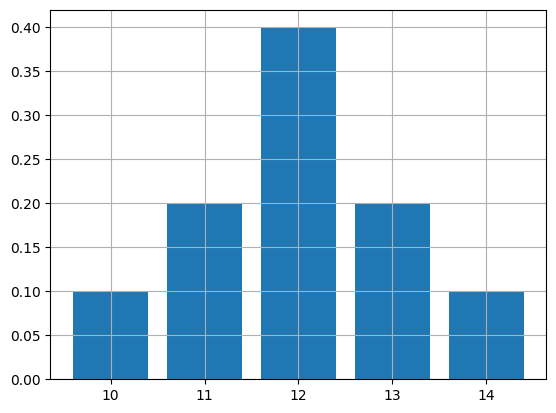

In [ ]:
probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position  # для гистограммы из начальных данных с учётом желаемой позиции
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)
plt.grid()

Как и следовало ожидать, наибольшая вероятность в желаемой ячейке, что продиктовано изначальным законом распределения погрешности положения

Составим распределение модели до измерения датчиком, то есть f_prior. Заполняем нулями все ячейки, которые лежат за пределами заданных условий в районе желаемой позиции

In [ ]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.2, 0.4,
       0.2, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

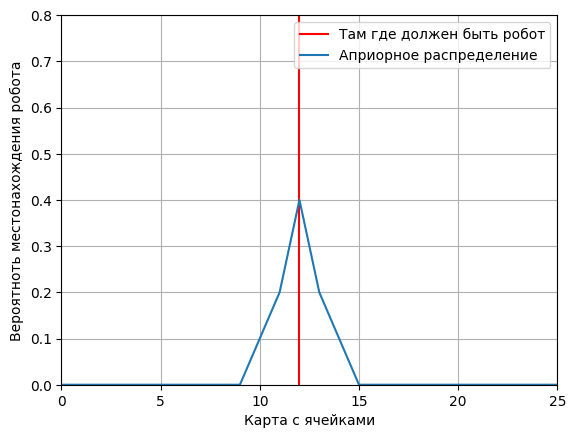

In [ ]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Там где должен быть робот")
ax.plot(search_area, f_prior, label = "Априорное распределение")
ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта с ячейками")
ax.set_ylabel("Вероятноть местонахождения робота")
ax.legend()
plt.grid()
plt.show()

### ***Часть 2.*** Функция, имитирующая измерение положения робота датчиком

Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

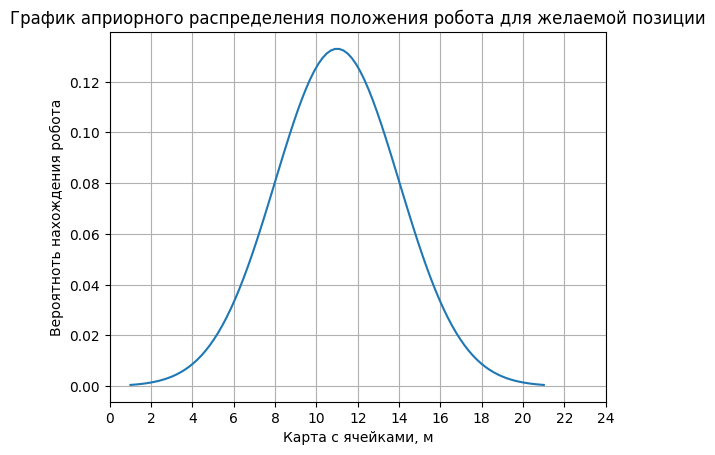

In [ ]:
def sens_pos_def(mu=0, sigma=3, N=100):
  x = np.linspace(mu-10, mu+10, N)
  p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
  return p, x

sens_pos, x = sens_pos_def(mu=real_position)  # задали реальное положение и с помощью функции для измерений датчика получили распределение для положения робота
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
plt.grid()
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))  # шаг по оси оХ
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

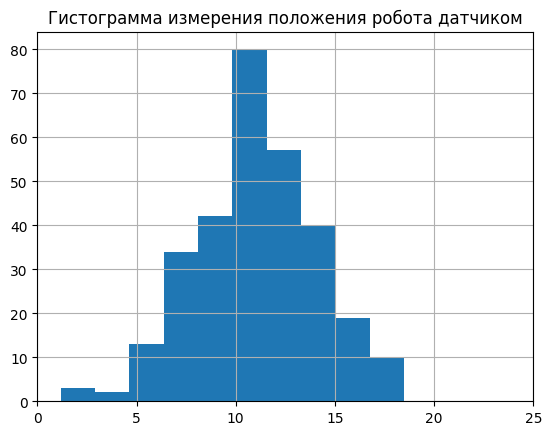

In [ ]:
N = 300  # число измерений
sigma = 3 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position  # генерируем вектор гипотез (замеров) местонахождения

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')
plt.grid()

### ***Часть 3.*** Реализация фильтра Байеса для определения положения робота

In [ ]:
from scipy.stats import norm

def bayes_formula(prior, y):
    numerator = []
    for i in range(len(search_area)):
        numerator.append(prior[i] * norm.pdf(x=y, loc=search_area[i], scale=sigma))
    return numerator/np.sum(numerator)

Функция работает следующим образом: в числителе происходит умножение по формуле Байеса, а именно - распределение до измерения умножается на заранее известное распределение модели измерения. Далее числитель делится на общую величину всех измерений. Процесс повторяется итеративно до тех пор, пока для всего вектора распределения до измерений (для каждой координаты в итоге) не будет рассчитано уточнённое распределение

In [ ]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  f_posteriors.append(f_posterior)

Происходит следующее: для каждого измерения, сделанного датчиком, на основе формулы Байеса происходит вычисление уточнённого распределения, после чего величина добавляется в итоговый массив уточнённых распределений

### ***Часть 4.*** График максимальной вероятности нахождения от количества замеров

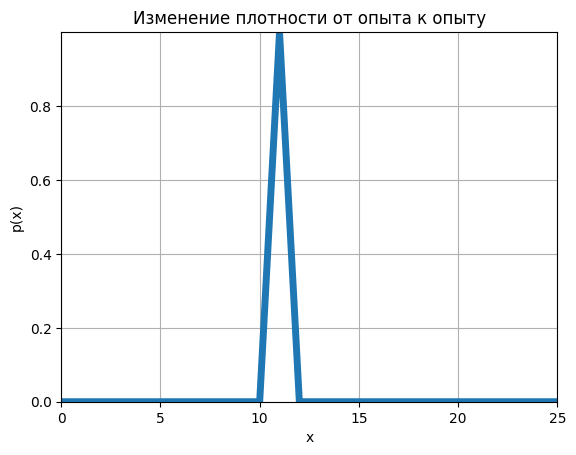

In [ ]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
plt.grid()
line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

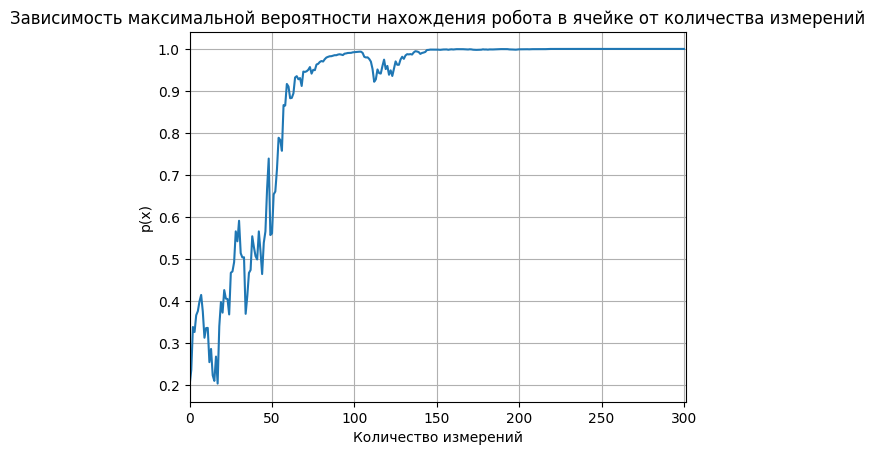

In [ ]:
probability = []
for i in range(len(f_posteriors)):
  probability.append(f_posteriors[i][real_position]) # интересует вероятность нахождения только в реальной позиции

x = range(len(f_posteriors))

plt.plot(x, probability)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

### ***Часть 5.*** Изменить положение с разными значениями отклонений

Желаемая позиция 5 метров 
Реальная позиция 6 метров


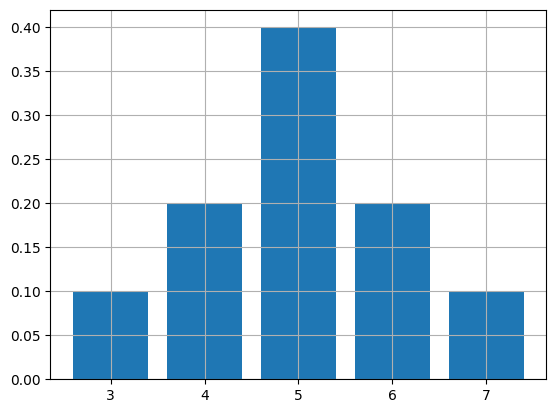

In [ ]:
desired_position = 5
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)
plt.grid()

Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

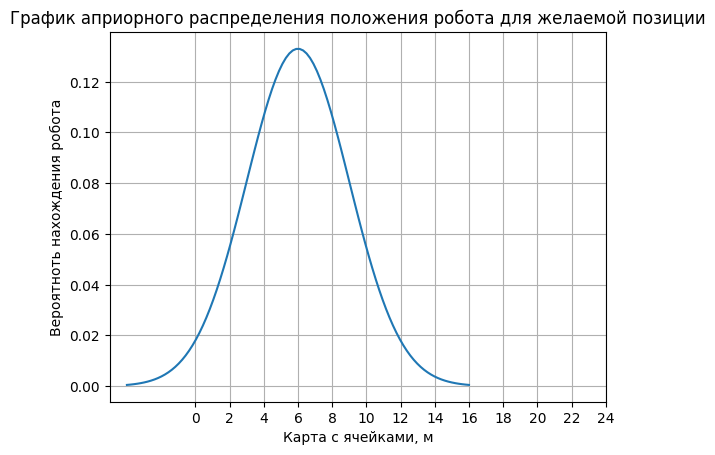

In [ ]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

sens_pos, x = sens_pos_def(mu=real_position)
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
plt.grid()
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

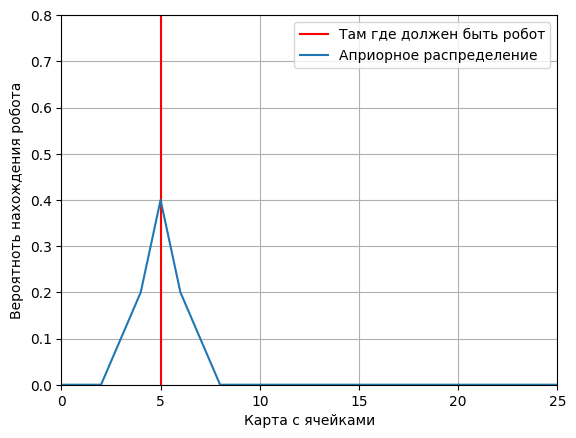

In [ ]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Там где должен быть робот")
ax.plot(search_area, f_prior, label = "Априорное распределение")
ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта с ячейками")
ax.set_ylabel("Вероятноть нахождения робота")
ax.legend()
plt.grid()
plt.show()

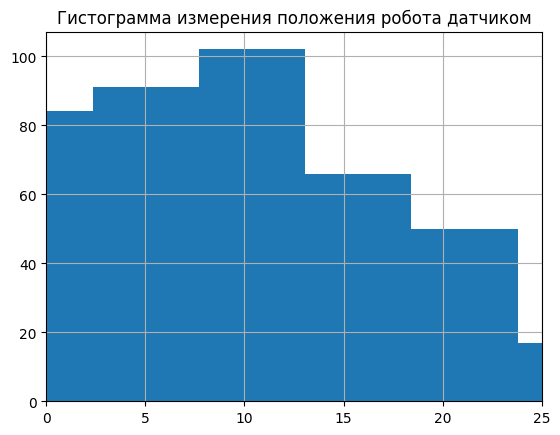

In [ ]:
N = 500  # число измерений
sigma = 10 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')
plt.grid()

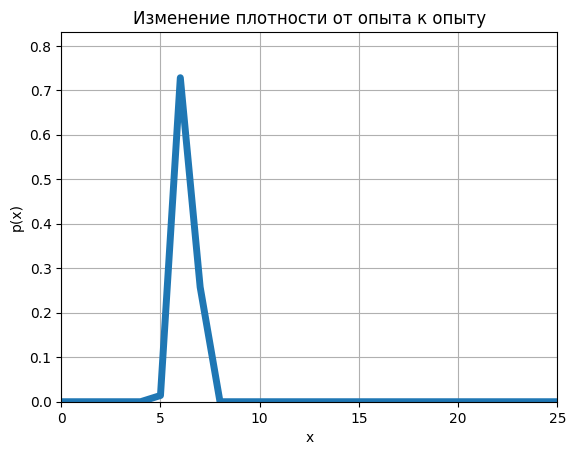

In [ ]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  f_posteriors.append(f_posterior)

%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
plt.grid()
line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors1.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

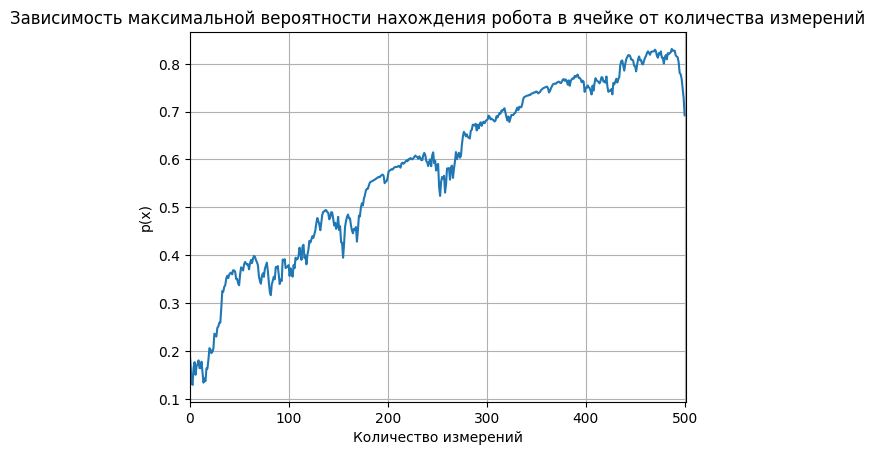

In [ ]:
probability1 = []
for i in range(len(f_posteriors)):
  probability1.append(f_posteriors[i][real_position])

x = range(len(f_posteriors))

plt.plot(x, probability1)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

### ***Часть 6.*** Изменить положение с разными значениями отклонений

Желаемая позиция 19 метров 
Реальная позиция 19 метров


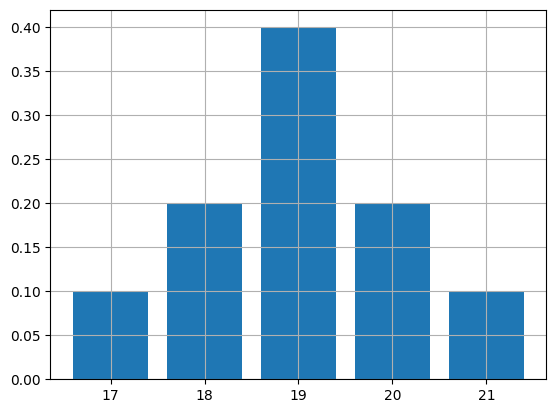

In [ ]:
desired_position = 19
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)
plt.grid()

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1
 0.2 0.4 0.2 0.1 0.  0.  0.  0. ]


Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

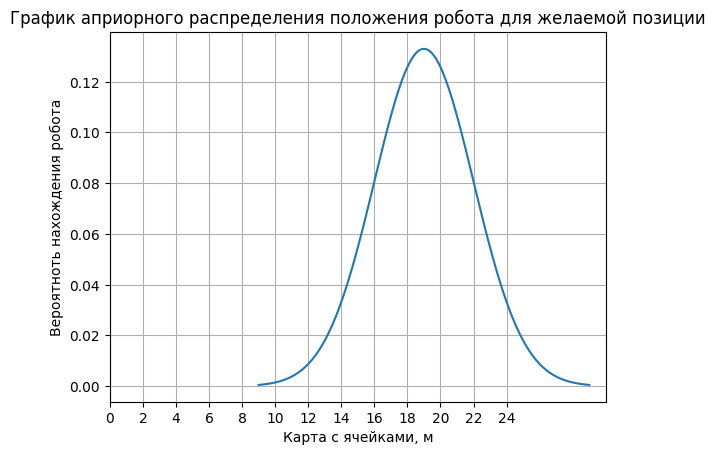

In [ ]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

print(f_prior)

sens_pos, x = sens_pos_def(mu=real_position)
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
plt.grid()
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

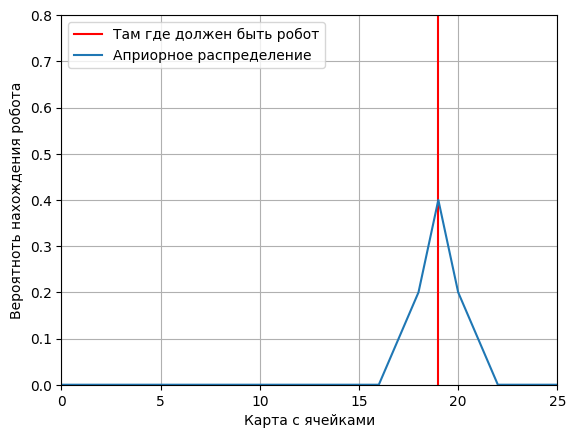

In [ ]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Там где должен быть робот")
ax.plot(search_area, f_prior, label = "Априорное распределение")
ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта с ячейками")
ax.set_ylabel("Вероятноть нахождения робота")
ax.legend()
plt.grid()
plt.show()

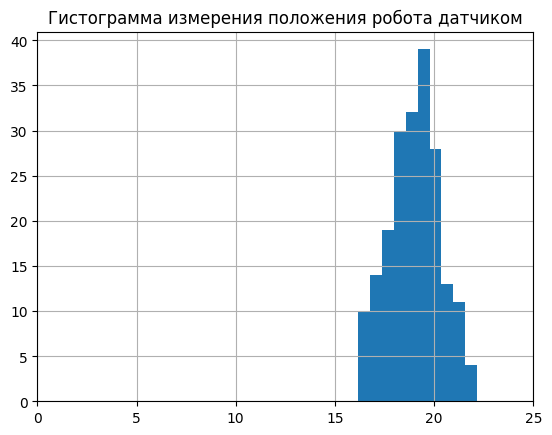

In [ ]:
N = 200  # число измерений
sigma = 1.3 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')
plt.grid()

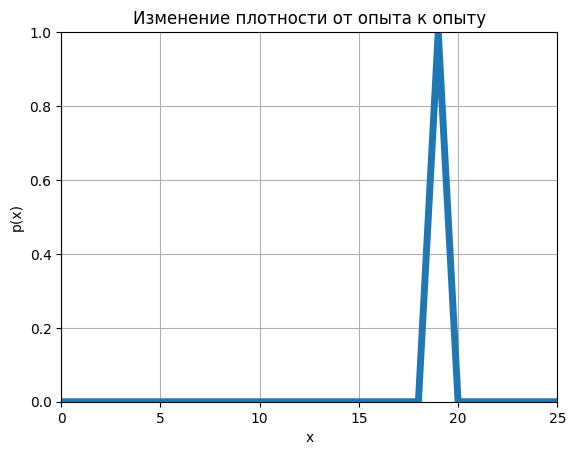

In [ ]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  f_posteriors.append(f_posterior)

%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
plt.grid()
line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors2.gif', writer='matplotlib.animation.PillowWriter')

range(0, 201)


Text(0.5, 1.0, 'Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

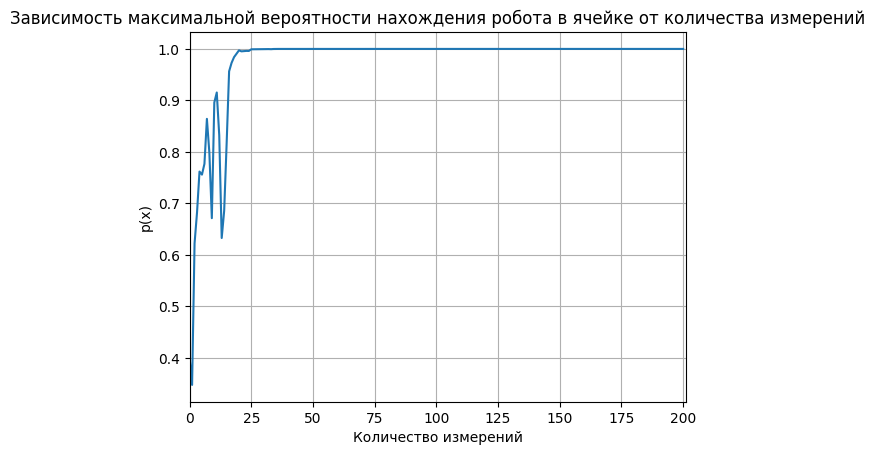

In [ ]:
probability2 = []
for i in range(len(f_posteriors)):
  probability2.append(f_posteriors[i][real_position])

x = range(len(f_posteriors))

plt.plot(x, probability2)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

## **Выводы**
В ходе выполнения лабораторной работы были выполнены следующие пункты:
+ Написана функция, имитирующая перемещение робота в заданную ячейку с учётом вероятности промаха
+ Написана функция, имитирующая работу датчика с заранее известным распределением (нормальное) для реальной позиции робота
+ Написана функция для расчёта фильтра Байеса
+ Построены 6 графиков плотности вероятности и максимальной вероятности в засисимости от количества измерений для трёх разных позиций при разных значениях среднеквадратического отклонения.\
При достаточно большом числе измерений можно добиться значения максимальной вероятности нахождения работа. Однако, если при этом значение квадратического отклонения относительно большое, то, в рамках задачи, даже 500 измерений может не хватить, чтобы обеспечить максимальную вероятность в районе 0.9